In [1]:
import numpy as np
from scipy.linalg import circulant
import time

import os 
import sys

import matplotlib.pyplot as plt 

os.chdir('/Users/miguel/Desktop/')
os.environ['PATH'] = os.environ['PATH'] + ':/Library/TeX/texbin'

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{cmbright}')

In [2]:
def kernel(theta, choice='left', maxv=1.0, shape='triangle'):
    k = np.ones_like(theta) * 0.0
    n = len(k)

    if shape == 'linear':
        k = np.ones_like(theta) * maxv
        if choice == 'left':
            k[n // 2:] = 0
        else:
            k[:n // 2] = 0
    elif shape == 'triangle':
        if choice == 'left':
            k = maxv * (-theta / np.pi)
        elif choice == 'right':
            k = maxv * (theta / np.pi)
    return k


def sigmoid(x):
    """Roxin, Ledberg 2008
    
    :param np.ndarray of float x: input current.
    :return: firing rate response.
    :rtype: np.ndarray of float 
    """
    alpha = 1.5
    beta = 2.5
    i0 = 1.0
    return alpha / (1 + np.exp(-beta * (x - i0)))


In [3]:
def fc(dc):
    """Fraction of correct trials
    
    :param class 'type' dc: object of class DC
    :return: percentage of correct trials
    :rtype: float
    """
    ntrials = (dc.params.get('d1').shape[-1] + dc.params.get('d2').shape[-1]) / 2
    if dc.params.get('I1') > dc.params.get('I2'):
        return np.sum(dc.params.get('d1')[-1] > dc.params.get('d2')[-1], axis=-1) / ntrials
    elif dc.params.get('I1') < dc.params.get('I2'):
        return np.sum(dc.params.get('d2')[-1] > dc.params.get('d1')[-1], axis=-1) / ntrials
    
def rt(dc, th):
    """Reaction time for decision trials
    
    :param class 'type' dc: object of class DC
    :return: average reaction time for decision trials
    :rtype: float
    """
    rt = np.empty(0)
    for idx in np.where(dc.params.get('d1')[-1, :] > th)[0]:
        rt = np.concatenate([rt, dc.params.get('tpoints')[np.array([np.where(dc.params.get('d1')[:, idx] > 0.7)[0][0]])]])
    return np.mean(rt)

In [4]:
class DC:
    def __init__(self):
        parameters = np.array(['dt',         # simulation time step (s)
                               'tmax',       # total time of the simulation
                               
                               # default neuron and network parameters
                               'dtauE',                        # time constant of rate equation for the excitatory population of neurons
                               'dtauI',                        # time constant of rate equation for the inhibitory population of neurons
                               
                               'rec_exc',      # recurrent excitation strength of excitatory population
                               'cross_inh',    # cross inhibition strength of excitatory population
                               'g',            # excitatory drive strength from excitatory population to inhibitory population
                               
                               'I1',    # external bias current to excitatory population of neurons of left circuit
                               'I2',    # external bias current to excitatory population of neurons of right circuit
                               'Ii',    # external bias current to inhibitory population of neurons 
                               'I',     # critical input at which bifurcation takes place
                               
                               'sigma_E', 'sigma_I'    # width of Gaussian white noise to excitatory and inhibitory populations
                              ])  
        
        values = np.zeros(parameters.shape)
        self.params = dict(zip(parameters, values))

        
    def prep(self, **kwargs):
        self.params.update(kwargs.items())
        
        # ---------------------------------------------------
        # Set up network, depending on the default parameters
        # ---------------------------------------------------
                
        self.params.update({'dtau': self.params.get('dtauE') / self.params.get('dtauI')}) 
        
        # initialize simulation
        self.params.update({'tpoints': np.arange(0, self.params.get('tmax'), self.params.get('dt')), 
                               'rsteps': len(np.arange(0, self.params.get('tmax'), self.params.get('dt'))), 
                               'nsteps': len(np.arange(0, self.params.get('tmax'), self.params.get('dt'))),
                           })
                
        self.params.update({'d1': np.zeros((self.params.get('nsteps'), kwargs.get('ntrials'))),
                            'd2': np.zeros((self.params.get('nsteps'), kwargs.get('ntrials'))),
                            'ri': np.zeros((self.params.get('nsteps'), kwargs.get('ntrials')))
                           })
        
        
    def run(self, **kwargs):    
        # Decision circuit network à la Roxin and Ledberg PLoS 2008
        dt, dtau = self.params.get('dt'), self.params.get('dtau')
        tmax = self.params.get('tmax')
        
        tpoints = self.params.get('tpoints')
        nsteps, rsteps = len(tpoints), len(tpoints)
        ntrials = self.params.get('ntrials')
                                           
        # default neuron and network parameters
        rec_exc, cross_inh, g = self.params.get('rec_exc'), self.params.get('cross_inh'), self.params.get('g')
        I1, I2, Ii, I = self.params.get('I1'), self.params.get('I2'), self.params.get('Ii'), self.params.get('I')
        sigma_E, sigma_I = self.params.get('sigma_E'), self.params.get('sigma_I')
        
        chi = np.random.normal(loc=0, scale=1, size=(3, nsteps, ntrials))    # unit variance Gaussian white noise
        
        tstep = 0
        temps = 0.0  
        
        # Simulation loop
        while temps < tmax:
            # Time step variables
            kp = tstep % rsteps
            k = (tstep + rsteps - 1) % rsteps

            try:
                input_1 = rec_exc * self.params.get('d1')[k] - cross_inh * self.params.get('ri')[k] + I + I1 
                input_2 = rec_exc * self.params.get('d2')[k] - cross_inh * self.params.get('ri')[k] + I + I2 
                input_i = g * (self.params.get('d1')[k] + self.params.get('d2')[k]) + Ii

                self.params.get('d1')[kp] = self.params.get('d1')[k] + dt * (-self.params.get('d1')[k] + sigmoid(input_1)) + np.sqrt(dt) * (sigma_E * chi[0, k]) 
                self.params.get('d2')[kp] = self.params.get('d2')[k] + dt * (-self.params.get('d2')[k] + sigmoid(input_2)) + np.sqrt(dt) * (sigma_E * chi[1, k])
                self.params.get('ri')[kp] = self.params.get('ri')[k] + dt / dtau * (-self.params.get('ri')[k] + sigmoid(input_i)) + np.sqrt(dt / dtau) * (sigma_I * chi[2, k]) 

            except FloatingPointError:
                self.params.get('d1')[self.params.get('d1') < 1E-12] = 0.0
                self.params.get('d2')[self.params.get('d2') < 1E-12] = 0.0
                self.params.get('ri')[self.params.get('ri') < 1E-12] = 0.0

            temps += dt
            tstep += 1

In [5]:
dc = DC()
dc.prep(tmax=2000.0, dt=1./40., dtauE=200.0, dtauI=200.0,
        rec_exc=1.9, cross_inh=1.0, g=1.0, I1=0.001, I2=-0.001, Ii=0.2, I=0.3679,
        sigma_E=0.001634, sigma_I=0.001634, 
        ntrials=1000)
dc.run()

In [6]:
start = time.time()

coh = np.logspace(0, 2, 15)
diff = 1e-5 * coh
i1, i2 = diff / 2, -diff / 2

fc_tr, rt_tr, und_tr = np.empty(0), np.empty(0), np.empty(0)

for i in range(diff.size):
    dc_tr = DC()
    dc_tr.prep(tmax=100.0, dt=1./40., dtauE=200.0, dtauI=200.0,
            rec_exc=1.9, cross_inh=1.0, g=1.0, sigma_E=0.001, sigma_I=0.001, 
            I1=0., I2=0., Ii=0., I=0.2,
            ntrials=1000)
    dc_tr.run()
    dc_tr.prep(tmax=2000.0, I1=i1[i], I2=i2[i], Ii=0.2, I=0.3679 + 0.001, ntrials=1000)
    dc_tr.run()
    
    fc_tr = np.concatenate([fc_tr, np.array([fc(dc_tr)])])
    rt_tr = np.concatenate([rt_tr, np.array([rt(dc_tr, th=0.7)])])
    und_tr = np.concatenate([und_tr, np.array([len(np.where((dc_tr.params.get('d1')[-1] < 0.7) & (dc_tr.params.get('d2')[-1] < 0.7))[0])])])
    del dc_tr
        
end = time.time()
print(end - start)

219.48731923103333


In [7]:
start = time.time()

coh = np.logspace(0, 2, 15)
diff = 1e-5 * coh
i1, i2 = diff / 2, -diff / 2

fc_sq, rt_sq, und_sq = np.empty(0), np.empty(0), np.empty(0)

for i in range(diff.size):
    dc_sq = DC()
    dc_sq.prep(tmax=100.0, dt=1./40., dtauE=200.0, dtauI=200.0,
            rec_exc=1.9, cross_inh=1.0, g=1.0, sigma_E=0.001, sigma_I=0.001, 
            I1=0., I2=0., Ii=0., I=0.2,
            ntrials=1000)
    dc_sq.run()
    dc_sq.prep(tmax=2000.0, I1=i1[i], I2=i2[i], Ii=0.2, I=0.3679, ntrials=1000)
    dc_sq.run()
    
    fc_sq = np.concatenate([fc_sq, np.array([fc(dc_sq)])])
    rt_sq = np.concatenate([rt_sq, np.array([rt(dc_sq, th=0.7)])])
    und_sq = np.concatenate([und_sq, np.array([len(np.where((dc_sq.params.get('d1')[-1] < 0.7) & (dc_sq.params.get('d2')[-1] < 0.7))[0])])])
    del dc_sq
    
end = time.time()
print(end - start)

225.9851541519165


In [8]:
start = time.time()

coh = np.logspace(0, 2, 15)
diff = 1e-5 * coh
i1, i2 = diff / 2, -diff / 2

fc_ci, rt_ci, und_ci = np.empty(0), np.empty(0), np.empty(0)

for i in range(diff.size):
    dc_ci = DC()
    dc_ci.prep(tmax=100.0, dt=1./40., dtauE=200.0, dtauI=200.0,
            rec_exc=1.9, cross_inh=1.0, g=1.0, sigma_E=0.001, sigma_I=0.001, 
            I1=0., I2=0., Ii=0., I=0.2,
            ntrials=1000)
    dc_ci.run()
    dc_ci.prep(tmax=2000.0, I1=i1[i], I2=i2[i], Ii=0.2, I=0.3679 + 0.0012, ntrials=1000)
    dc_ci.run()
    
    fc_ci = np.concatenate([fc_ci, np.array([fc(dc_ci)])])
    rt_ci = np.concatenate([rt_ci, np.array([rt(dc_ci, th=0.7)])])
    und_ci = np.concatenate([und_ci, np.array([len(np.where((dc_ci.params.get('d1')[-1] < 0.7) & (dc_ci.params.get('d2')[-1] < 0.7))[0])])])
    del dc_ci
        
end = time.time()
print(end - start)

215.5846049785614


In [9]:
start = time.time()

coh = np.logspace(0, 2, 15)
diff = 1e-5 * coh
i1, i2 = diff / 2, -diff / 2

fc_di, rt_di, und_di = np.empty(0), np.empty(0), np.empty(0) 

for i in range(diff.size):
    dc_di = DC()
    dc_di.prep(tmax=100.0, dt=1./40., dtauE=200.0, dtauI=200.0,
            rec_exc=1.9, cross_inh=1.0, g=1.0, sigma_E=0.001, sigma_I=0.001, 
            I1=0., I2=0., Ii=0., I=0.2,
            ntrials=1000)
    dc_di.run()
    dc_di.prep(tmax=2000.0, I1=i1[i], I2=i2[i], Ii=0.2, I=0.3679 + 0.0321, ntrials=1000)
    dc_di.run()
    
    fc_di = np.concatenate([fc_di, np.array([fc(dc_di)])])
    rt_di = np.concatenate([rt_di, np.array([rt(dc_di, th=0.7)])])
    und_di = np.concatenate([und_di, np.array([len(np.where((dc_di.params.get('d1')[-1] < 0.7) & (dc_di.params.get('d2')[-1] < 0.7))[0])])])
    del dc_di
        
end = time.time()
print(end - start)

224.85498809814453


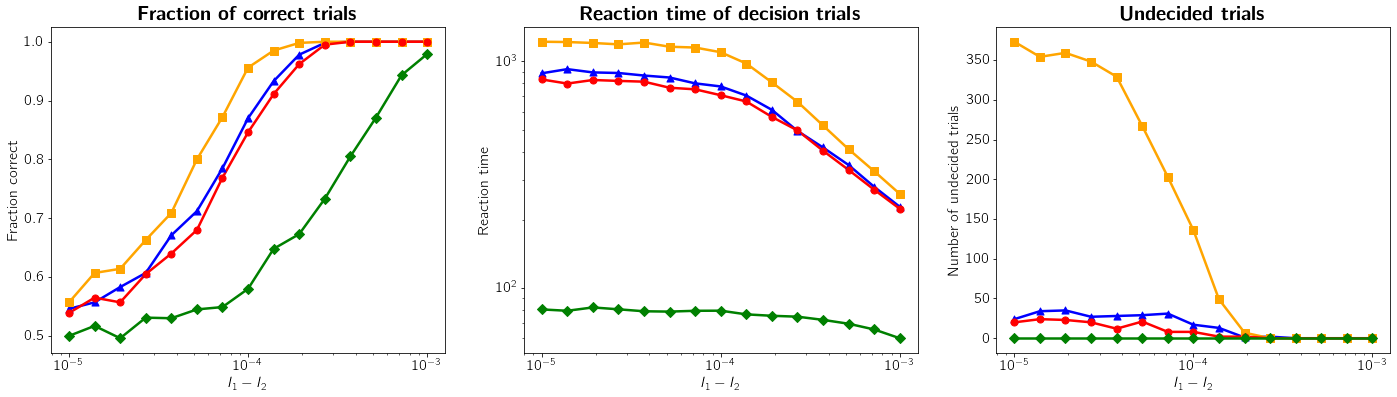

In [40]:
coh = np.logspace(0, 2, 15)
diff = 1e-5 * coh

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

ax1.plot(diff, fc_tr, c='blue', lw=2.5, zorder=1)
ax1.scatter(diff, fc_tr, c='blue', marker='^', s=50, zorder=2)
ax1.plot(diff, fc_sq, c='orange', lw=2.5, zorder=1)
ax1.scatter(diff, fc_sq, c='orange', marker='s', s=50, zorder=2)
ax1.plot(diff, fc_ci, c='red', lw=2.5, zorder=1)
ax1.scatter(diff, fc_ci, c='red', marker='o', s=50, zorder=2)
ax1.plot(diff, fc_di, c='green', lw=2.5, zorder=1)
ax1.scatter(diff, fc_di, c='green', marker='D', s=50, zorder=2)

ax1.set_xlabel('$I_1 - I_2$', fontsize=15)
ax1.set_ylabel('Fraction correct', fontsize=15)
ax1.set_title('\\textbf{Fraction of correct trials}', fontsize=20)
ax1.set_xscale('log')
ax1.tick_params(axis='both', which='major', labelsize=15)

ax2.plot(diff, rt_tr, c='blue', lw=2.5, zorder=1)
ax2.scatter(diff, rt_tr, c='blue', marker='^', s=50, zorder=2)
ax2.plot(diff, rt_sq, c='orange', lw=2.5, zorder=1)
ax2.scatter(diff, rt_sq, c='orange', marker='s', s=50, zorder=2)
ax2.plot(diff, rt_ci, c='red', lw=2.5, zorder=1)
ax2.scatter(diff, rt_ci, c='red', marker='o', s=50, zorder=2)
ax2.plot(diff, rt_di, c='green', lw=2.5, zorder=1)
ax2.scatter(diff, rt_di, c='green', marker='D', s=50, zorder=2)

ax2.set_xlabel('$I_1 - I_2$', fontsize=15)
ax2.set_ylabel('Reaction time', fontsize=15)
ax2.set_title('\\textbf{Reaction time of decision trials}', fontsize=20)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.tick_params(axis='both', which='major', labelsize=15)

ax3.plot(diff, und_tr, c='blue', lw=2.5, zorder=1)
ax3.scatter(diff, und_tr, c='blue', marker='^', s=50, zorder=2)
ax3.plot(diff, und_sq, c='orange', lw=2.5, zorder=1)
ax3.scatter(diff, und_sq, c='orange', marker='s', s=50, zorder=2)
ax3.plot(diff, und_ci, c='red', lw=2.5, zorder=1)
ax3.scatter(diff, und_ci, c='red', marker='o', s=50, zorder=2)
ax3.plot(diff, und_di, c='green', lw=2.5, zorder=1)
ax3.scatter(diff, und_di, c='green', marker='D', s=50, zorder=2)

ax3.set_xlabel('$I_1 - I_2$', fontsize=15)
ax3.set_ylabel('Number of undecided trials', fontsize=15)
ax3.set_title('\\textbf{Undecided trials}', fontsize=20)
ax3.set_xscale('log')
ax3.tick_params(axis='both', which='major', labelsize=15)

plt.show()

#### Fit to data from Roitman and Shadlen

In [11]:
start = time.time()

# Stimulus input (Fig. 3)
coh = np.logspace(0, 2, 15)
diff = 2.168e-5 * coh
i1, i2 = diff / 2, -diff / 2

fc_rl3, rt_rl3 = np.empty(0), np.empty(0)    # fraction correct and reaction time results to reproduce Figure 3 of Roxin and Ledberg 2008

for i in range(diff.size):
    dc = DC()
    dc.prep(tmax=2000.0, dt=1./40., dtauE=200.0, dtauI=200.0,
            rec_exc=1.9, cross_inh=1.0, g=1.0, sigma_E=0.001634, sigma_I=0.001634, 
            I1=i1[i], I2=i2[i], Ii=0.2, I=0.3695,
            ntrials=1000)
    dc.run()
    
    fc_rl3 = np.concatenate([fc_rl3, np.array([fc(dc)])])
    rt_rl3 = np.concatenate([rt_rl3, np.array([rt(dc, th=0.7)])])
    del dc
    
rt_rl3 += 230
        
end = time.time()
print(end - start)

215.59582209587097


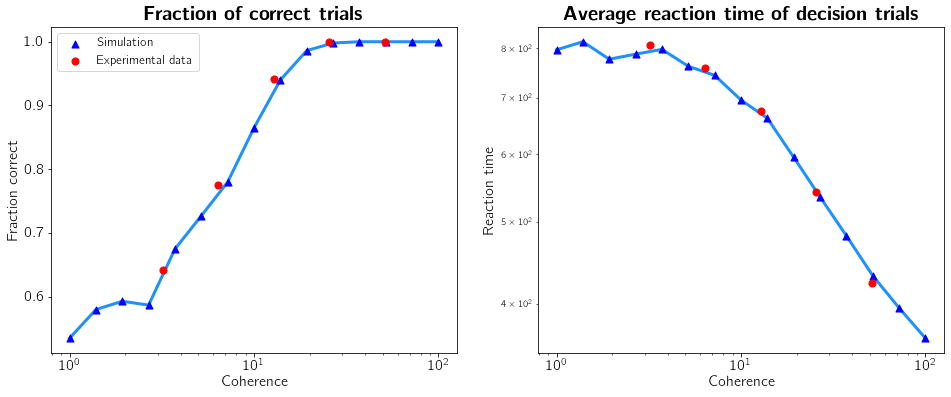

In [31]:
coh = np.logspace(0, 2, 15)

fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(121)
ax1.plot(coh, fc_rl3, c='dodgerblue', lw=3, zorder=1, label='_nolegend_')
ax1.scatter(coh, fc_rl3, c='blue', marker='^', s=50, zorder=2)
ax1.scatter(np.array([3.2, 6.4, 12.8, 25.6, 51.2]), np.array([0.642, 0.776, 0.941, 1, 1]), c='red', marker='o', s=50, zorder=3)
ax1.legend(['Simulation', 'Experimental data'], fontsize=12.5)

ax1.set_xlabel('Coherence', fontsize=15)
ax1.set_ylabel('Fraction correct', fontsize=15)
ax1.set_title('\\textbf{Fraction of correct trials}', fontsize=20)
ax1.set_xscale('log')
ax1.tick_params(axis='both', which='major', labelsize=15)

ax2 = fig.add_subplot(122)
ax2.plot(coh, rt_rl3, c='dodgerblue', lw=3, zorder=1)
ax2.scatter(coh, rt_rl3, c='blue', marker='^', s=50, zorder=2)
ax2.scatter(np.array([3.2, 6.4, 12.8, 25.6, 51.2]), np.array([(795.0 + 818.3) / 2, (758.5 + 758.3) / 2, (671.8 + 678.1) / 2, (532.4 + 551.1) / 2, (409.3 + 436.9) / 2]), 
            c='red', marker='o', s=50, zorder=3)

ax2.set_xlabel('Coherence', fontsize=15)
ax2.set_ylabel('Reaction time', fontsize=15)
ax2.set_title('\\textbf{Average reaction time of decision trials}', fontsize=20)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.tick_params(axis='both', which='major', labelsize=15)

plt.show()